# GNN Training

In this notebook, a custom [PyTorch Geometric](https://rusty1s.github.io/pytorch_geometric/build/html/index.html) [InMemoryDataset](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/in_memory_dataset.html#InMemoryDataset) for the DAVIS 2016 dataset is created. The implementation is based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/create_dataset.html). The dataset is then used to train Graph Neural Networks as a first evaluation based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/introduction.html#learning-methods-on-graphs).

The dataset consists of single PyTorch Geometric [Data](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/data.html#Data) objects which model a single graph with various attributes. For this dataset, a graph for each contour is created. Hereby, each node of the graph represents one contour point. The feature of each node is the OSVOS feature vector from the next frame at this point. Each node is connected to its K nearest neighbours. The feature of each edge is the distance between the nodes it connects. The targets of each node is the translation it undergoes from the current to the next frame.

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler
from torch_geometric.data import DataLoader

from pg_networks.dynamic_edge import DynamicEdge
from pg_networks.gcn import GCN
from pg_networks.sg import SG
from src.davis_2016 import DAVIS2016
from src.solver import Solver
from src.vis_utils import plot_img_with_contour_and_translation, plot_translations, plot_loss, \
                          plot_combo_img

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Paths & Constants

In [2]:
PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH = 'pg_datasets/DAVIS_2016'
CONTOURS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Contours/480p'
IMAGES_FOLDERS_PATH = 'DAVIS_2016/DAVIS/JPEGImages/480p'
TRANSLATIONS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Translations/480p'

SKIP_SEQUENCES = []

#SKIP_SEQUENCES = ['bmx-trees', 'bus', 'cows', 'dog-agility', 'horsejump-high', 
#                 'horsejump-low', 'kite-walk', 'lucia', 'libby', 'motorbike',
#                 'paragliding', 'rhino', 'scooter-gray', 'swing']

TRAIN_SEQUENCES = ['bear', 'bmx-bumps', 'boat', 'breakdance-flare', 'bus', 
                   'car-turn', 'dance-jump', 'dog-agility', 'drift-turn', 
                   'elephant', 'flamingo', 'hike', 'hockey', 'horsejump-low', 
                   'kite-walk', 'lucia', 'mallard-fly', 'mallard-water', 
                   'motocross-bumps', 'motorbike', 'paragliding', 'rhino', 
                   'rollerblade', 'scooter-gray', 'soccerball', 'stroller',
                   'surf', 'swing', 'tennis', 'train']

VAL_SEQUENCES = ['blackswan', 'bmx-trees', 'breakdance', 'camel', 'car-roundabout',
                 'car-shadow', 'cows', 'dance-twirl', 'dog', 'drift-chicane', 
                 'drift-straight', 'goat', 'horsejump-high', 'kite-surf', 'libby', 
                 'motocross-jump', 'paragliding-launch', 'parkour', 'scooter-black', 
                 'soapbox']

# Dataset parameters
EPOCHS_WO_AVEGRAD = 200
LAYER = 9
K = 32
NUM_SEQUENCES = 10

# Training parameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.0
NUM_EPOCHS = 20
EPOCHS_WO_AVEGRAD = 200

## Train and Val Dataset

In [3]:
train = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                  CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                  LAYER, K, EPOCHS_WO_AVEGRAD,
                  SKIP_SEQUENCES, TRAIN_SEQUENCES[:NUM_SEQUENCES], VAL_SEQUENCES[:NUM_SEQUENCES],
                  train=True)

In [4]:
val = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                LAYER, K, EPOCHS_WO_AVEGRAD,
                SKIP_SEQUENCES, TRAIN_SEQUENCES[:NUM_SEQUENCES], VAL_SEQUENCES[:NUM_SEQUENCES],
                train=False)

In [ ]:
print("Train size: %i" % len(train))
print("Val size: %i" % len(val))

Train size: 667
Val size: 715


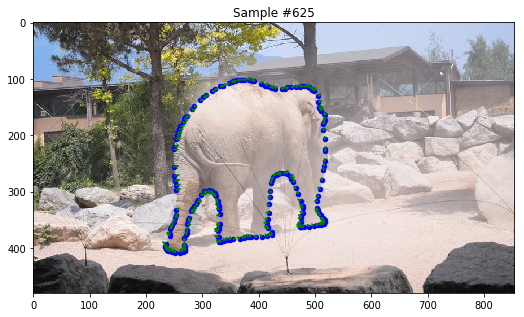

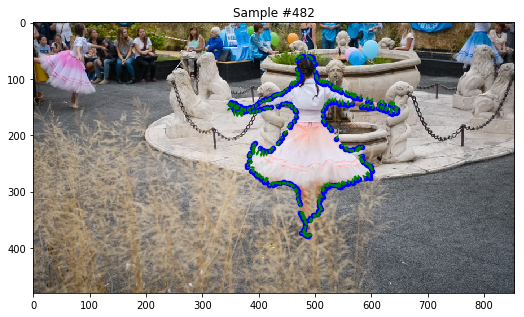

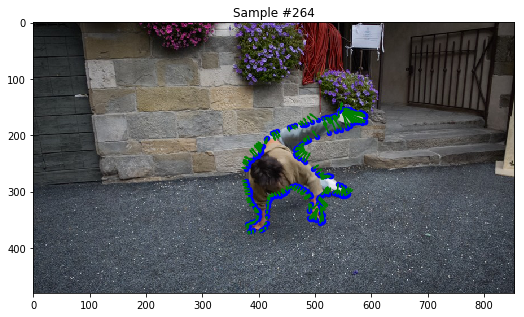

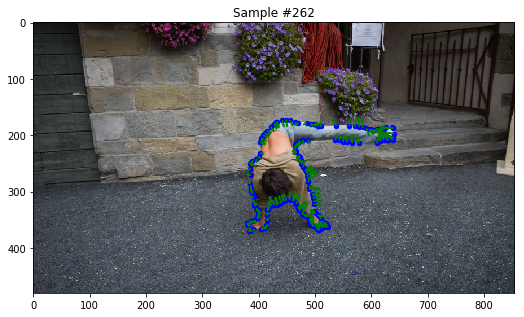

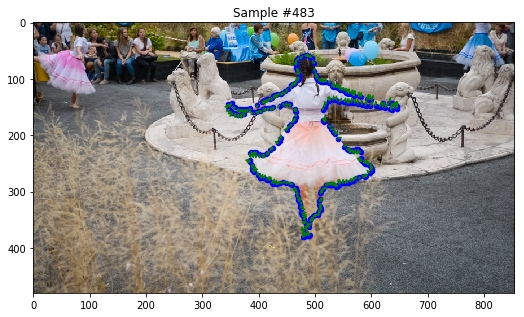

In [ ]:
num_to_display = 5

for i in range(num_to_display):
    
    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(train))
    data = train[rand_i]
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_img_with_contour_and_translation(data.img, data.contour, data.y)

## Simple GCN

In [ ]:
data = train[0]

model = GCN(in_channels=data.num_features, 
            out_channels=data.y.shape[1])

print(model)

GCN(
  (conv1): GCNConv(256, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 1024)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
)


### Overfit

In [ ]:
num_train = 80
num_val = 20

overfit_train_loader = DataLoader(train, batch_size=16, 
                                  shuffle=False, sampler=SequentialSampler(range(num_train)))
overfit_val_loader = DataLoader(train, batch_size=1, 
                                shuffle=False, sampler=SequentialSampler(range(num_val)))

# Load model and run the solver
overfit_model = GCN(in_channels=data.num_features, 
                    out_channels=data.y.shape[1])

overfit_solver = Solver(optim_args={"lr": LEARNING_RATE})
overfit_solver.train(overfit_model, overfit_train_loader, overfit_val_loader,
                     num_epochs=5, log_nth=100, verbose=True)

#Save model
torch.save(model.state_dict(), 'pg_models/Bear_overfit_model.pth')

START TRAIN.


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Epoch 1/5] train_loss: 130.76155 - val_loss: 9.56048
[Epoch 2/5] train_loss: 6.52179 - val_loss: 6.99564
[Epoch 3/5] train_loss: 4.97346 - val_loss: 4.99335
[Epoch 4/5] train_loss: 3.84321 - val_loss: 4.47487
[Epoch 5/5] train_loss: 3.34639 - val_loss: 4.81725
FINISH.


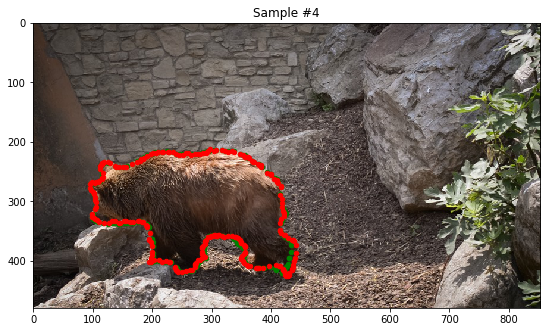

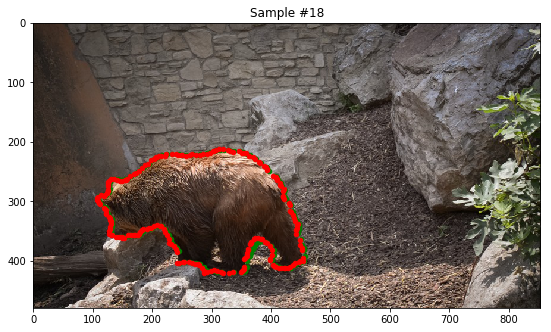

In [ ]:
overfit_model.cpu()
overfit_model.double()
overfit_model.eval()
num_to_display = 2

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, num_val)
    data = train[rand_i]
    
    with torch.no_grad():
        translation_pred = overfit_model(data)
        
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(data.img, data.contour, data.y, translation_pred)    

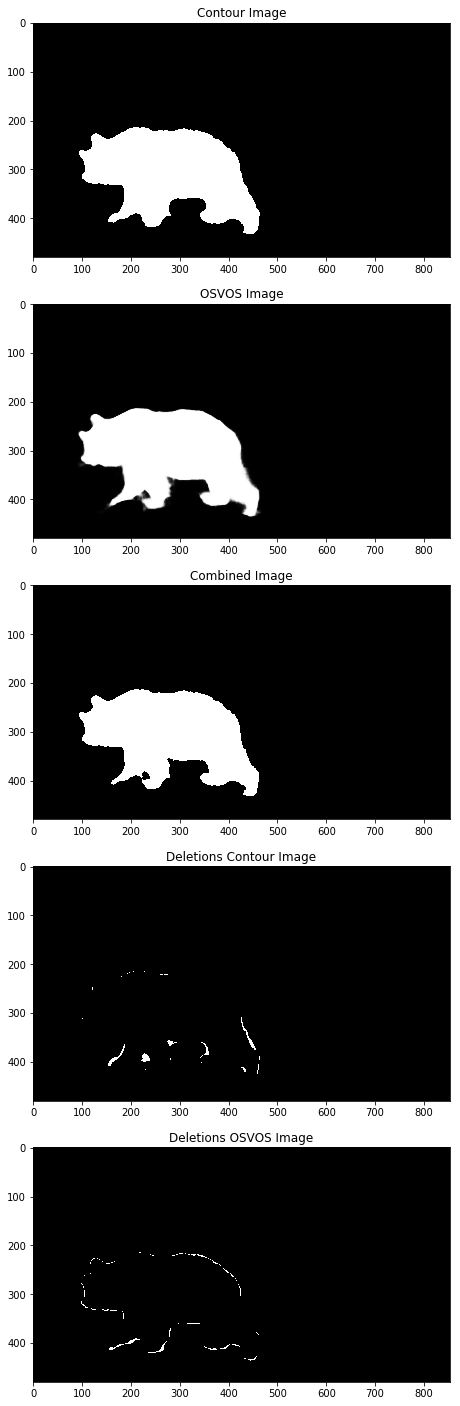

In [ ]:
#Show test run for one example image
original_img = 'DAVIS_2016/DAVIS/JPEGImages/480p/bear/00001.png'
osvos_img = cv2.imread('OSVOS_PyTorch/models/Results/bear/00001.png')
contour_0 = train[0].contour
translation_0_1_pred = overfit_model(train[0])
contour_1_pred = contour_0.type(torch.DoubleTensor).add(translation_0_1_pred)

plot_combo_img(contour_1_pred, osvos_img)

### Train

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

# Load model and run the solver
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

solver = Solver(optim_args={"lr": LEARNING_RATE,
                            "weight_decay": WEIGHT_DECAY})

solver.train(model, train_loader, val_loader,
             num_epochs=NUM_EPOCHS, log_nth=100, verbose=True)

torch.save(model.state_dict(), 'pg_models/trained_model.pth')

START TRAIN.
[Epoch 1/20] train_loss: 112.86875 - val_loss: 36.88905
[Epoch 2/20] train_loss: 57.77053 - val_loss: 37.17220
[Epoch 3/20] train_loss: 55.27867 - val_loss: 37.37173
[Epoch 4/20] train_loss: 54.87173 - val_loss: 37.64448
[Epoch 5/20] train_loss: 53.67989 - val_loss: 37.65736
[Epoch 6/20] train_loss: 53.38022 - val_loss: 38.73346


In [ ]:
plot_loss(solver)

### Display trained outputs

In [ ]:
model.cpu()
model.double()
model.eval()
num_to_display = 5

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(val))
    data = val[rand_i]
    
    with torch.no_grad():
        translation_pred = model(data)
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(data.img, data.contour, data.y, translation_pred) 

### Hyperparameter Tuning

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

learning_rates = [1e-2, 1e-4, 1e-6]
weight_decays = [1e-0, 1e-2, 1e-4]

best_model = None
best_loss = 1e10

i = 0
for learning_rate in learning_rates:
    if i == 0: break
    for weight_decay in weight_decays:
        model = GCN(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])
        solver = Solver(optim_args={"lr": LEARNING_RATE,
                            "weight_decay": WEIGHT_DECAY})
        solver.train(model, train_loader, val_loader,
             num_epochs=20, log_nth=100, verbose=False)

        # Predict on the validation set
        val_loss = max(solver.val_loss_history)
        print('Hyperparamter Tuning #', i + 1,
                'lr: ', learning_rate,
                'wd: ', weight_decay,
                'val_loss: ', val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

        i += 1